In [342]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as ticker

sns.set(style="whitegrid")

from api.questrade import QTClient

In [344]:
REFRESH_TOKEN = "edV19WQzVACHuC3sfzeX6Qv0UIOwNpoA0"

In [345]:
client = QTClient(REFRESH_TOKEN)

# Show Open PnL

In [346]:
positions = pd.DataFrame(client.get_account_positions())
positions

,averageEntryPrice,closedPnl,closedQuantity,currentMarketValue,currentPrice,dayPnl,isRealTime,isUnderReorg,openPnl,openQuantity,symbol,symbolId,totalCost
0,40.800000,0,0,187.85,37.57,-4.80,False,False,-16.150000,5,ROBO,4807280,204.000000
1,23.510000,0,0,234.20,23.42,-6.00,False,False,-0.900000,10,TAN,21806477,235.100000
2,23.398317,0,0,228.60,19.05,-5.64,False,False,-52.179804,12,BOTZ,15029143,280.779804


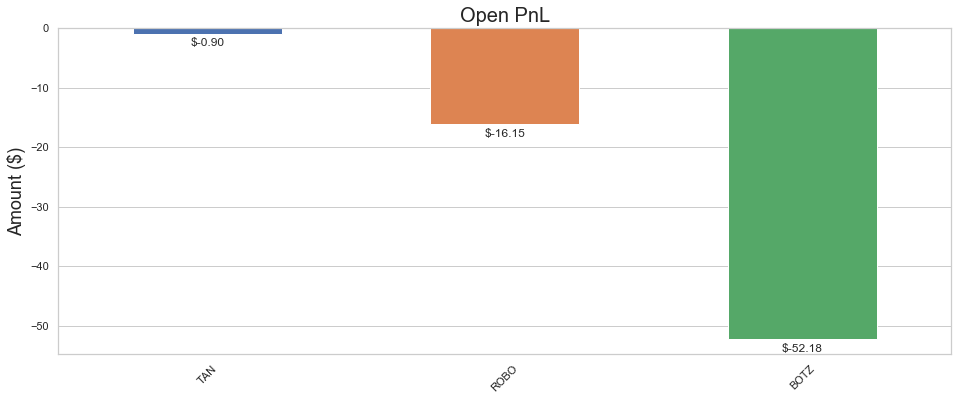

In [347]:
%matplotlib inline
positions.sort_values(by=['openPnl'], inplace=True, ascending=False)
ax = positions.plot(x='symbol', y='openPnl', kind='bar', figsize=(16, 6), legend=False)
ax.set_title('Open PnL', fontsize=20)
ax.set_ylabel('Amount ($)', fontsize=18)
ax.set_xlabel('')
ax.grid(axis='x')
rects = ax.patches
for rect, label in zip(rects, positions['openPnl']):
    height = rect.get_height()
    if height < 0:
        height -= 2.5
    ax.text(rect.get_x() + rect.get_width() / 2, height, '$%.2f' % label,
            ha='center', va='bottom', fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [348]:
print("Open PnL: %f" % (positions['openPnl'].sum()))

Open PnL: -69.229804


# Stitch market data for all securities into one DataFrame

## Add other securities to the list

In [461]:
watch_securities = pd.read_csv('/Users/kzabashta/Downloads/seclist.csv', 
                               names=["ticker", "description"]).set_index("ticker")

In [524]:
symbols = dict(zip(positions["symbolId"], positions["symbol"]))

watch_securities = pd.read_csv('/Users/kzabashta/Downloads/seclist.csv', 
                               names=["ticker", "description"]).set_index("ticker")
additional_securities = list(watch_securities.index)

for symbol in additional_securities:
    matched_securities = client.search(symbol)
    if len(matched_securities) > 1:
        if not "." in matched_securities[0]['symbol'] and len(matched_securities[0]['symbol'].split()) == 1:
            match_symbol = symbol.split()[0].strip()
            match = list(filter(lambda x: x['symbol'] == "%s.TO" % match_symbol and x["isTradable"] == True, 
                                matched_securities))
            if len(match) == 1:
                print("%s <=> %s" %(symbol, match[0]['symbol']))
                symbols[match[0]['symbolId']] = match[0]['symbol']
            else:
                print("%s <=> %s" % (symbol, matched_securities[0]['symbol']))
                symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']
        else:
            print("%s <=> %s" %(symbol, matched_securities[0]['symbol']))
            symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']

CDZ CN <=> CDZ.TO
CRQ CN <=> CRQ.TO
FXM CN <=> FXM.TO
HEX CN <=> HEX.TO
HIX CN <=> HIX.TO
HXT CN <=> HXT.TO
PDC CN <=> PDC.TO
VCE CN <=> VCE.TO
VCN CN <=> VCN.TO
WXM CN <=> WXM.TO
XCS CN <=> XCS.TO
XDV CN <=> XDV.TO
XIU CN <=> XIU.TO
XMD CN <=> XMD.TO
XTR CN <=> XTR.TO
ZCN CN <=> ZCN.TO
ZDV CN <=> ZDV.TO
CHB CN <=> CHB.TO
CIE CN <=> CIE.TO
CJP CN <=> CJP.TO
CLU CN <=> CLU.C.TO
CUD CN <=> CUD.TO
CWO CN <=> CWO.TO
CYH CN <=> CYH.TO
EHE CN <=> EHE.B.TO
ETHI CN <=> ETHI.TO
FTN CN <=> FTN.PRA.TO
HAZ CN <=> HAZ.IN
HCN CN <=> HCN.TO
HIU CN <=> HIU.TO
HSH CN <=> HSH.TO
HUV CN <=> HUV.IN
HXQ CN <=> HXQ.TO
HXS CN <=> HXS.TO
PDF CN <=> PDF.TO
TXF CN <=> TXF.TO
VDU CN <=> VDU.TO
VEE CN <=> VEE.TO
VEF CN <=> VEF.TO
VFV CN <=> VFV.TO
VGH CN <=> VGH.IN
VLQ CN <=> VLQ.TO
VMO CN <=> VMO.TO
VSP CN <=> VSP.TO
VUN CN <=> VUN.TO
VUS CN <=> VUS.TO
VVL CN <=> VVL.TO
VXC CN <=> VXC.TO
VXM CN <=> VXM.B.TO
XDG CN <=> XDG.TO
XDU CN <=> XDU.TO
XEC CN <=> XEC.TO
XEH CN <=> XEH.TO
XEM CN <=> XEM.TO
XFI CN <=> XFI.I

In [525]:
FROM_DATE = '2016-10-01T00:00:00-05:00'
TO_DATE = '2019-10-20T23:59:59-05:00'

historicals = pd.DataFrame()
for symbolId, symbol in symbols.items():
    print(symbol)
    try:
        candles = pd.DataFrame(client.get_candles(symbolId, FROM_DATE, TO_DATE, 'OneDay')['candles'])
        candles['end'] =  pd.to_datetime(candles['end'], format='%Y-%m-%d')
        candles['symbol'] = symbol
        candles['symbolId'] = symbol_id
        historicals = historicals.append(candles)
    except:
        print ("Could not get market data for %s" % symbol)
historicals = historicals.set_index(["symbol", "end"])

TAN
ROBO
BOTZ
CDZ.TO
CRQ.TO
FXM.TO
HEX.TO
HIX.TO
HXT.TO
PDC.TO
VCE.TO
VCN.TO
WXM.TO
XCS.TO
XDV.TO
XIU.TO
XMD.TO
XTR.TO
ZCN.TO
ZDV.TO
CHB.TO
CIE.TO
CJP.TO
CLU.C.TO
CUD.TO
CWO.TO
CYH.TO
EHE.B.TO
ETHI.TO
FTN.PRA.TO
HAZ.IN
HCN.TO
HIU.TO
HSH.TO
HUV.IN
HXQ.TO
HXS.TO
PDF.TO
TXF.TO
VDU.TO
VEE.TO
VEF.TO
VFV.TO
VGH.IN
VLQ.TO
VMO.TO
VSP.TO
VUN.TO
VUS.TO
VVL.TO
VXC.TO
VXM.B.TO
XDG.TO
XDU.TO
XEC.TO
XEH.TO
XEM.TO
XFI.IN
XID.IN
XIN.TO
XMC.TO
XMI.IN
XSP.TO
XSU.TO
XUS.TO
XXM.B.TO
YXM.B.TO
ZBK.TO
ZDY.TO
ZDM.TO
ZEM.TO
ZSP.TO
ZXM.B.TO
CEW.TO
CGR.TO
CIC.TO
CIF.TO
FIE.TO
HEF.TO
HFU.TO
MIND.TO
XCD.TO
XEN.TO
XFN.TO
ZEB.TO
ZGD.TO
ZIN.TO
ZMT.TO
ZRE.TO
ZWB.TO
HBB.TO
PSA.TO
TDB.TO
VAB.TO
ZAG.TO
CLF.TO
CLG.TO
HTB.TO
HTH.TO
PGL.TO
VSB.TO
VSC.TO
XEB.TO
XLB.TO
ZFL.TO
ZPL.TO
ZRR.TO
CBH.TO
CBO.TO
HAB.TO
PSB.TO
VCB.TO
XHB.TO
XQB.TO
XSH.TO
ZCS.L.TO
ZHY.TO
ZLC.TO
CMR.TO
CPD.TO
CSD.TO
CVD.TO
HFR.TO
HPR.TO
HYI.TO
XFR.TO
ZPR.TO
ZPS.L.TO
CGL.C.TO
HBD.TO
HBU.TO
HND.TO
HNU.TO
HNY.TO
HOD.TO
HOU.TO
HUC.TO
HUG.TO
SVR.C.TO
DLR.TO
A

# Plot historical data

['BOTZ', 'CDZ.TO', 'CHB.TO', 'CIE.TO', 'CJP.TO', 'CLU.C.TO', 'CRQ.TO', 'CUD.TO', 'CWO.TO', 'CYH.TO', 'EHE.B.TO', 'ETHI.TO', 'FTN.PRA.TO', 'FXM.TO', 'HCN.TO', 'HEX.TO', 'HIU.TO', 'HIX.TO', 'HSH.TO', 'HXQ.TO', 'HXS.TO', 'HXT.TO', 'PDC.TO', 'PDF.TO', 'ROBO', 'TAN', 'TXF.TO', 'VCE.TO', 'VCN.TO', 'VDU.TO', 'VEE.TO', 'VEF.TO', 'VFV.TO', 'VLQ.TO', 'VMO.TO', 'VSP.TO', 'VUN.TO', 'VUS.TO', 'VVL.TO', 'VXC.TO', 'VXM.B.TO', 'WXM.TO', 'XCS.TO', 'XDG.TO', 'XDU.TO', 'XDV.TO', 'XEC.TO', 'XEH.TO', 'XEM.TO', 'XIN.TO', 'XIU.TO', 'XMC.TO', 'XMD.TO', 'XSP.TO', 'XSU.TO', 'XTR.TO', 'XUS.TO', 'XXM.B.TO', 'YXM.B.TO', 'ZBK.TO', 'ZCN.TO', 'ZDM.TO', 'ZDV.TO', 'ZDY.TO', 'ZEM.TO', 'ZSP.TO', 'ZXM.B.TO']


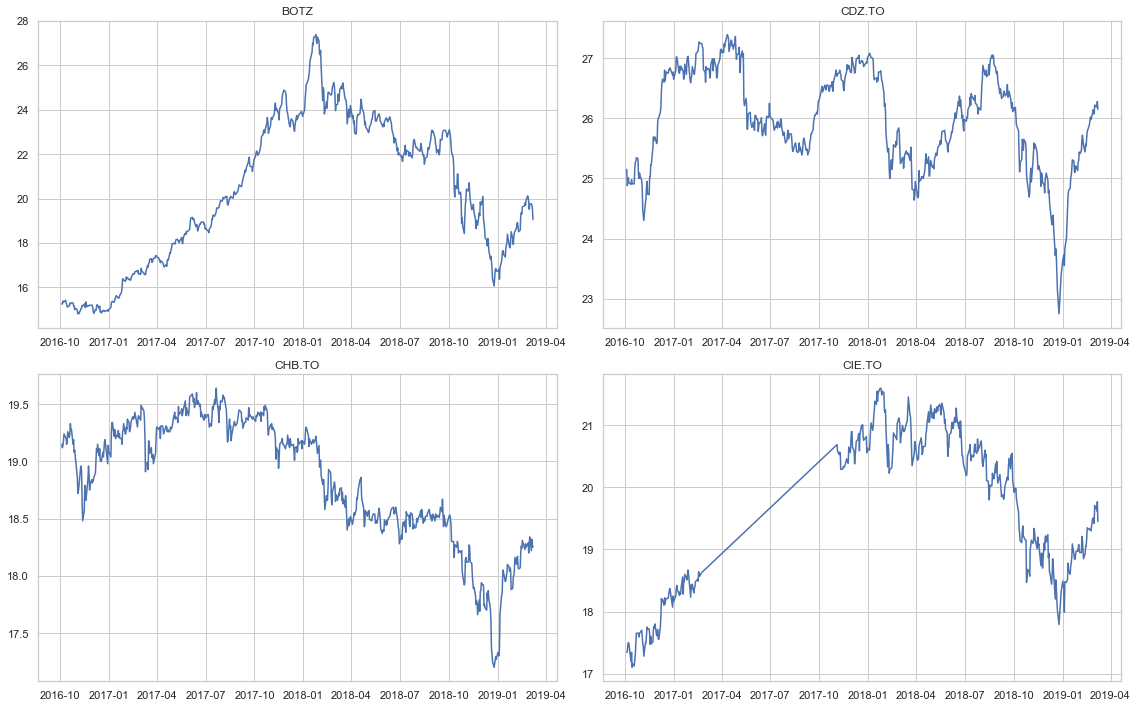

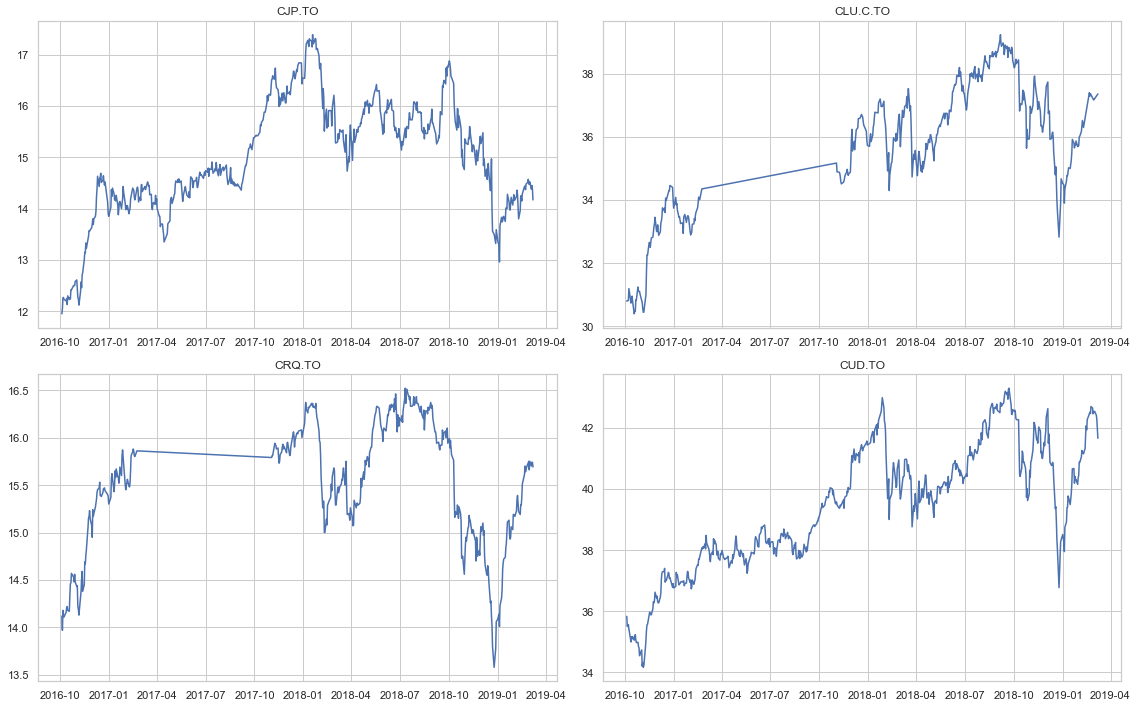

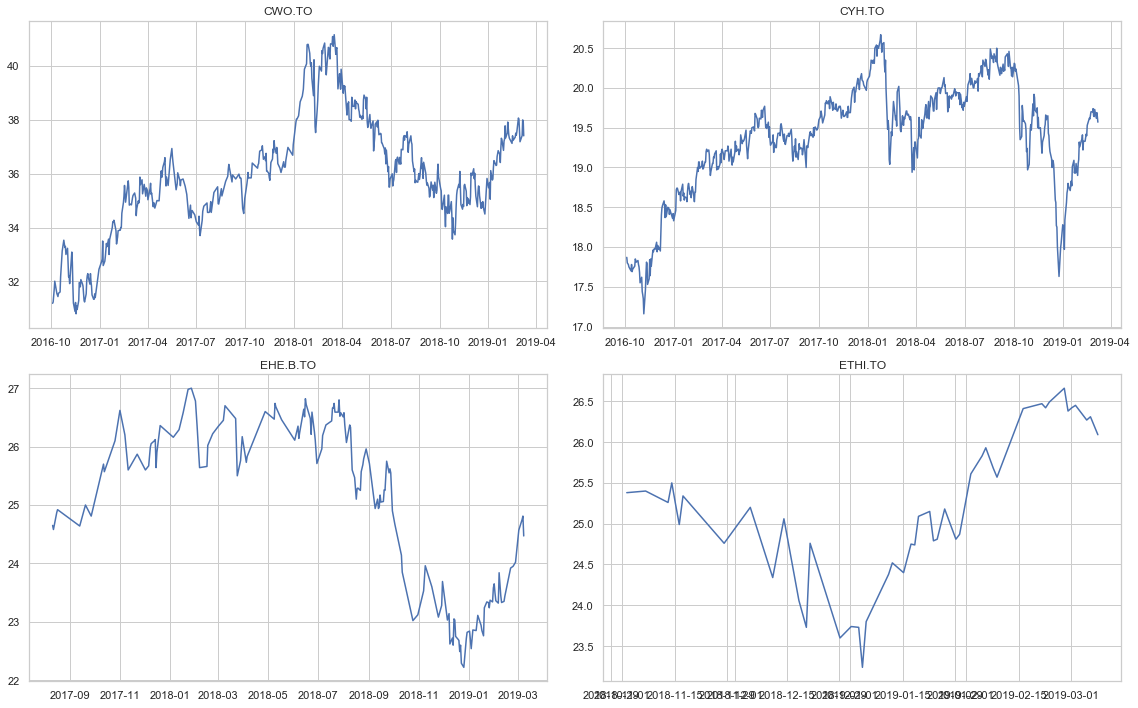

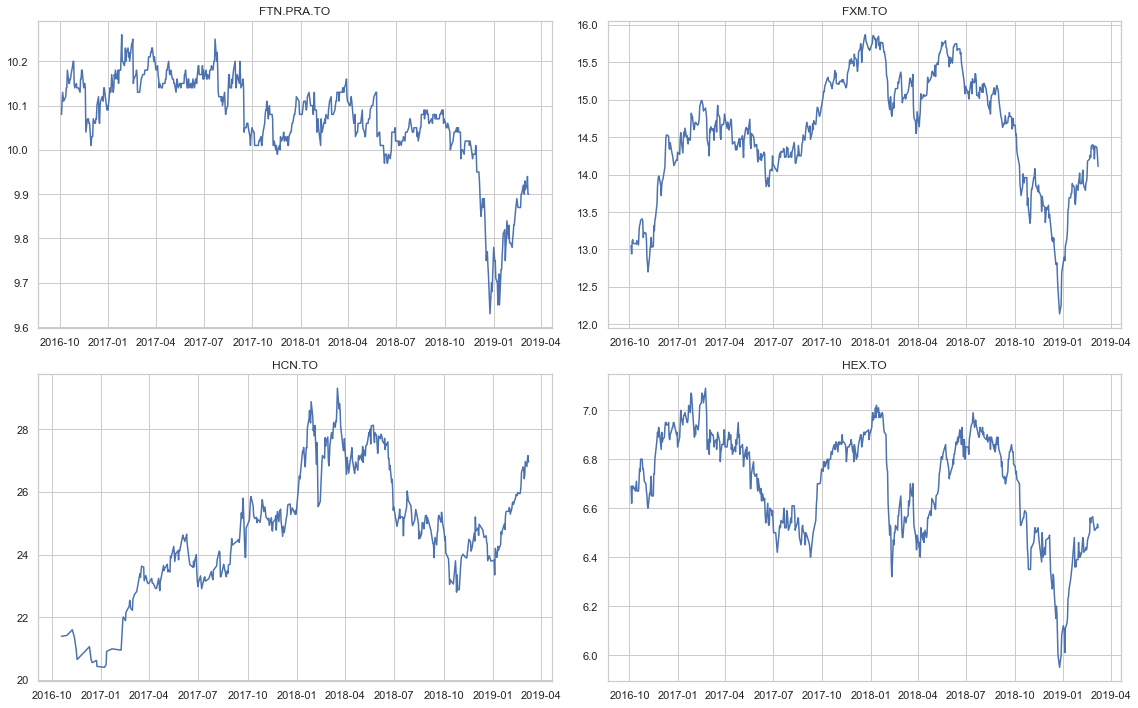

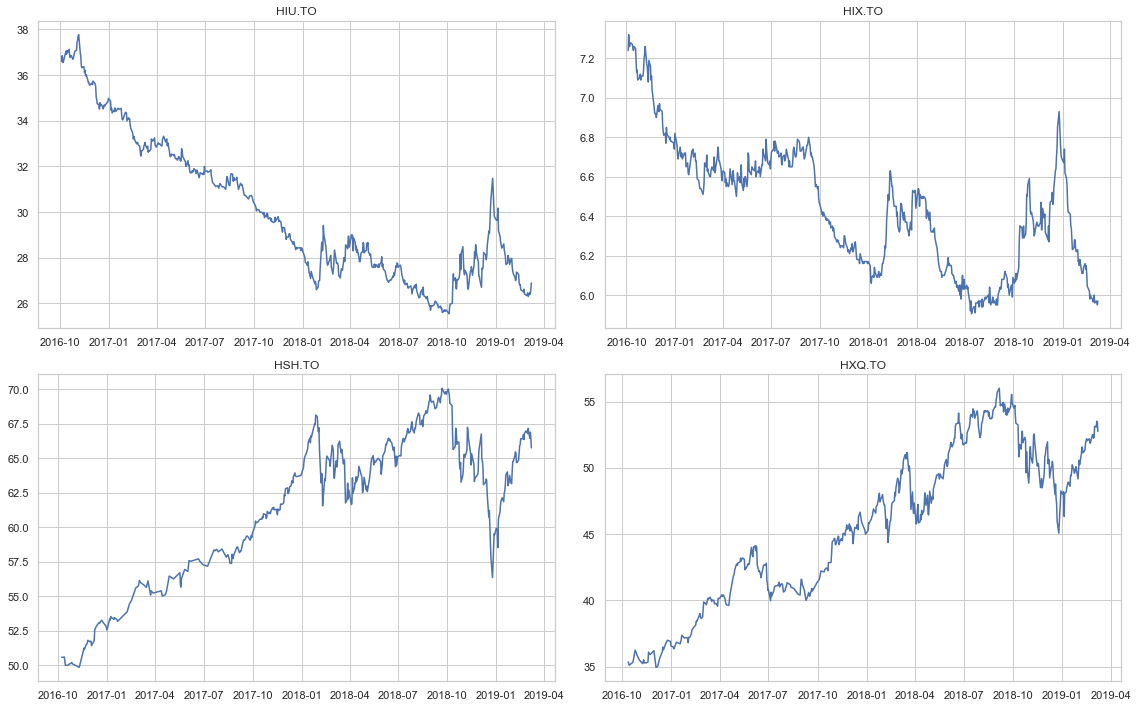

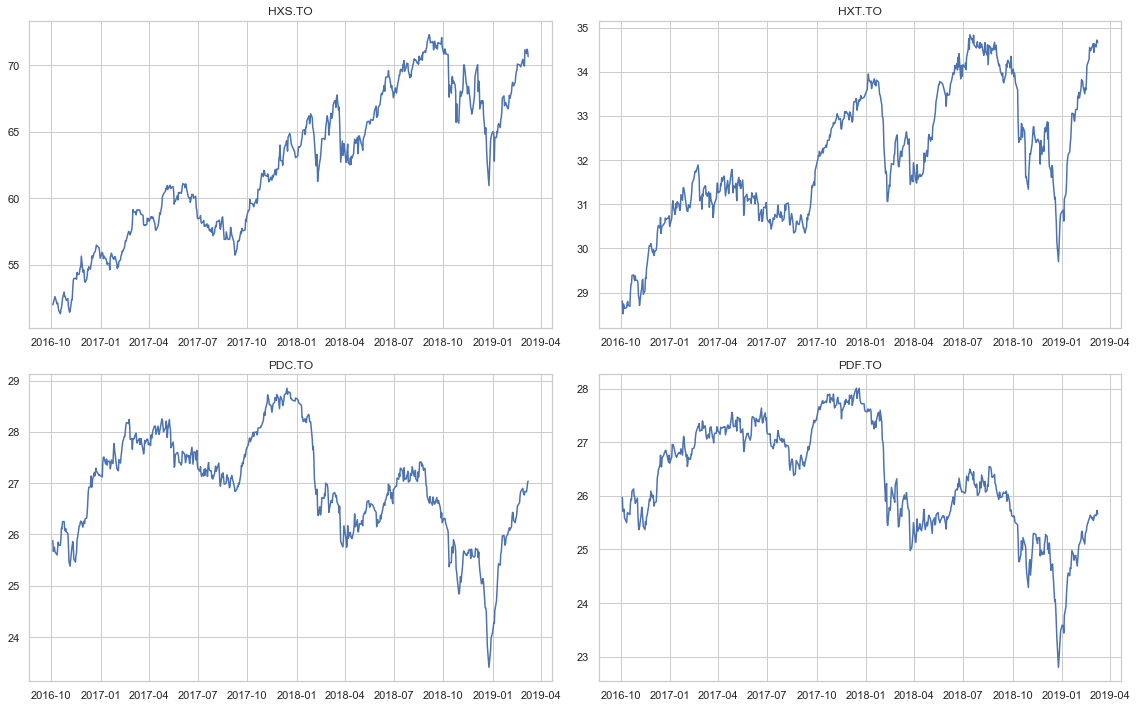

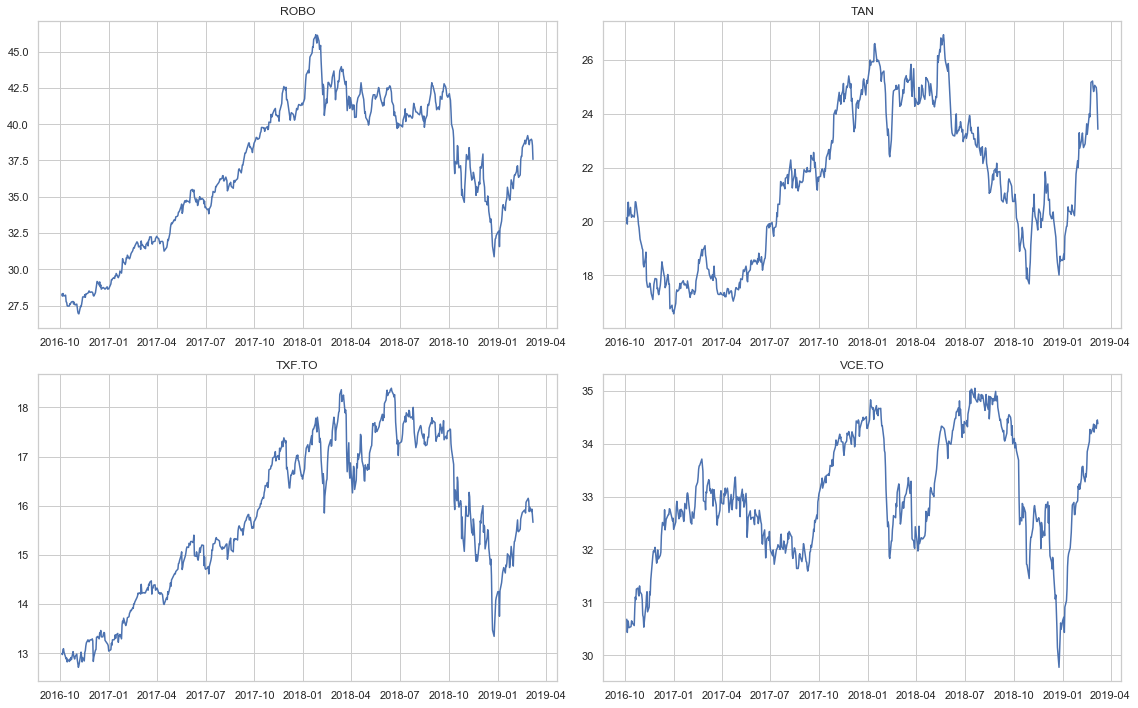

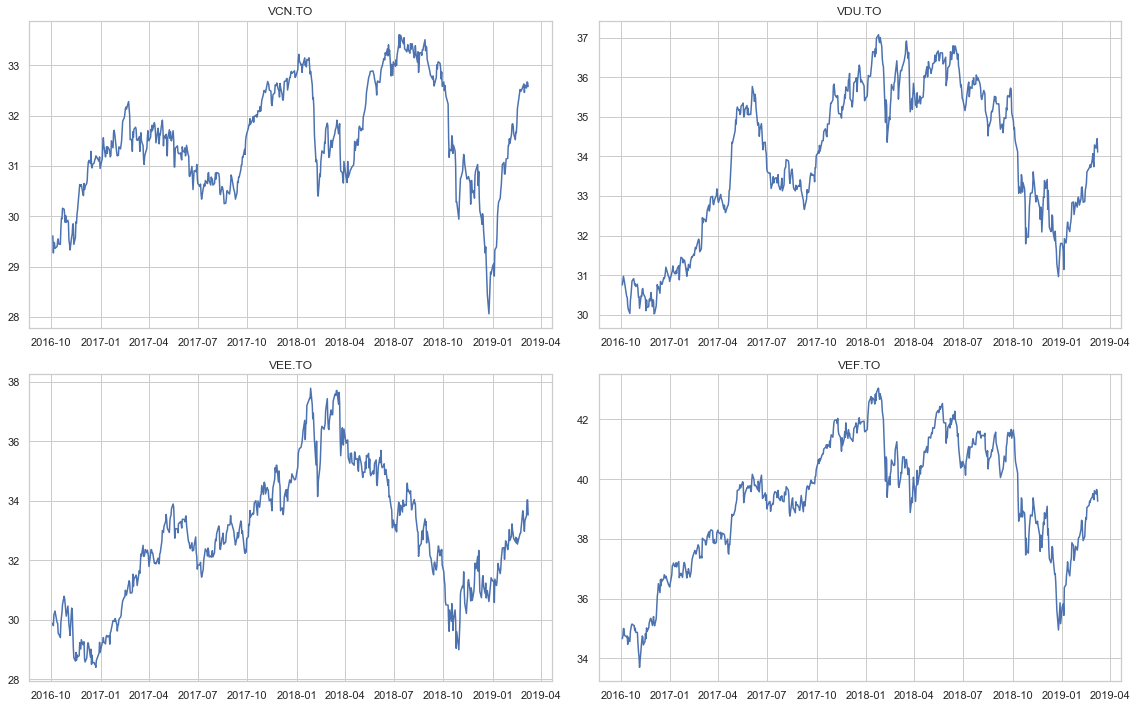

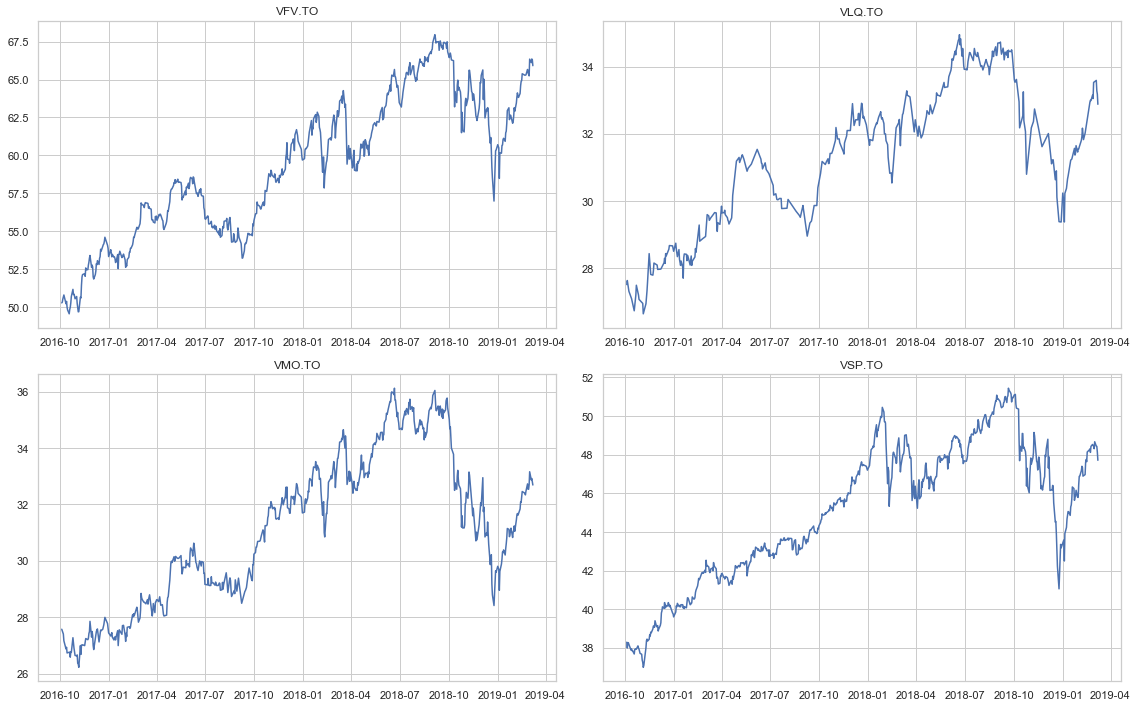

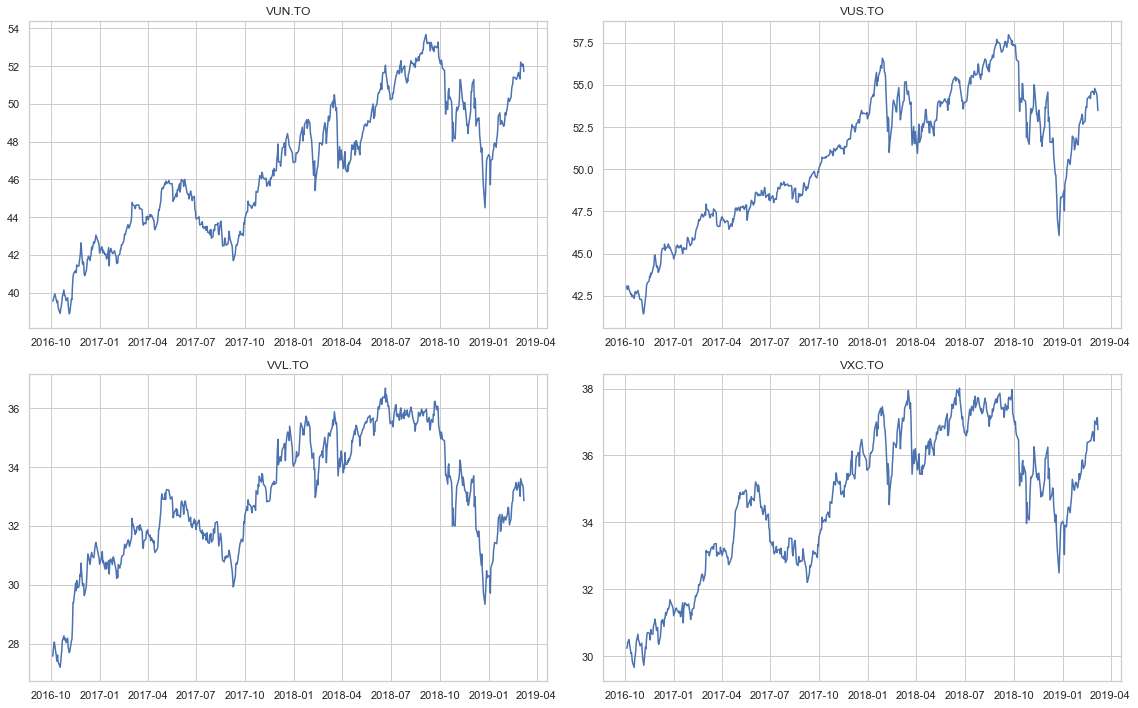

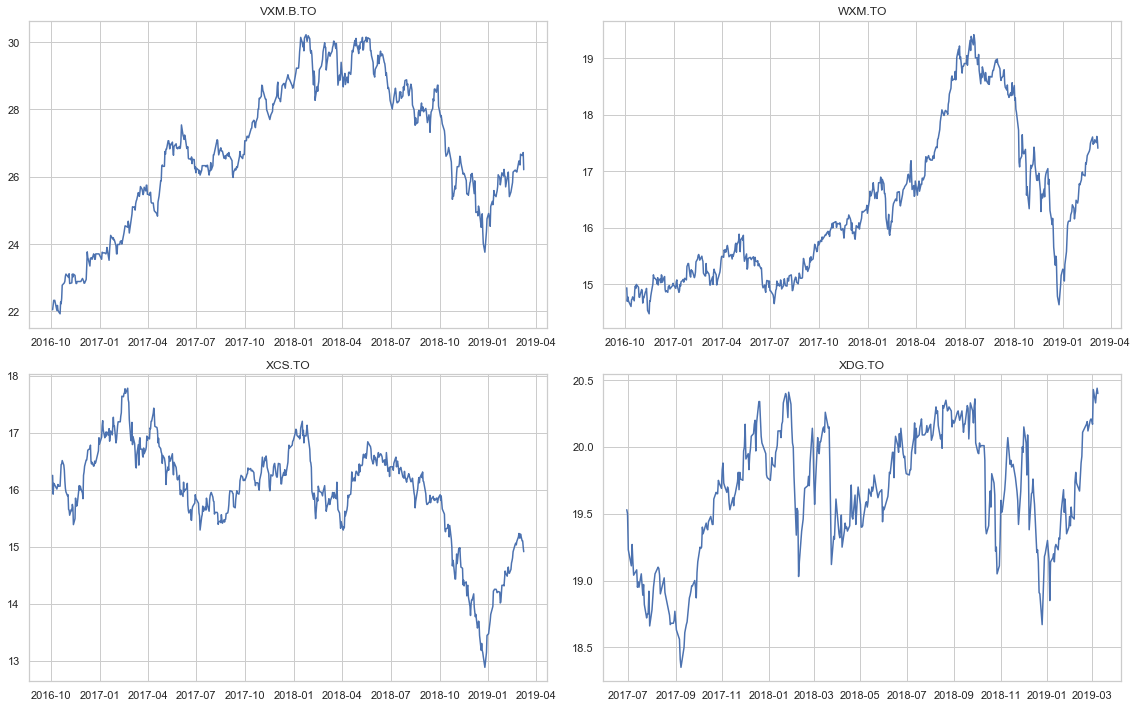

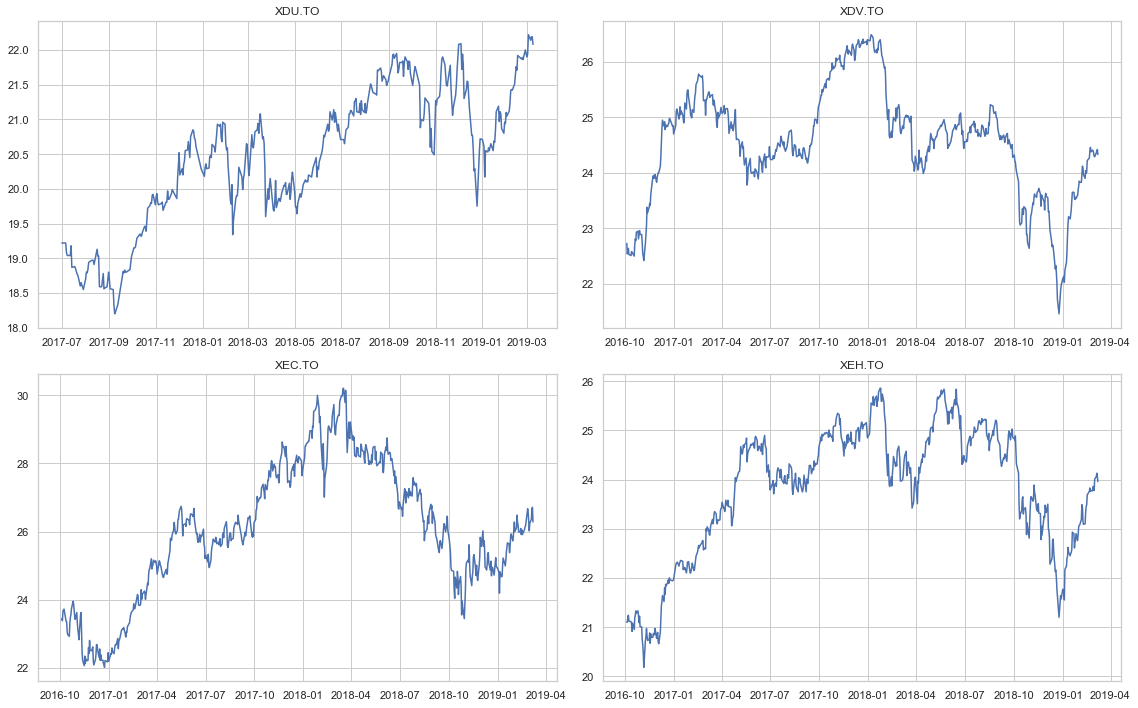

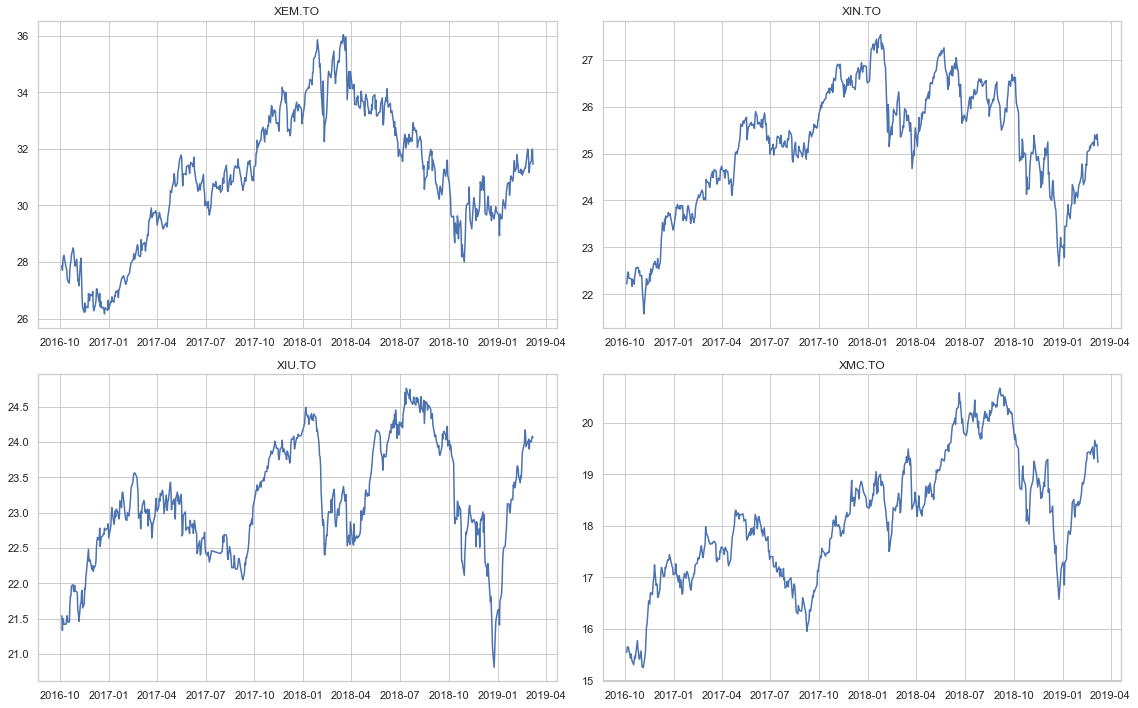

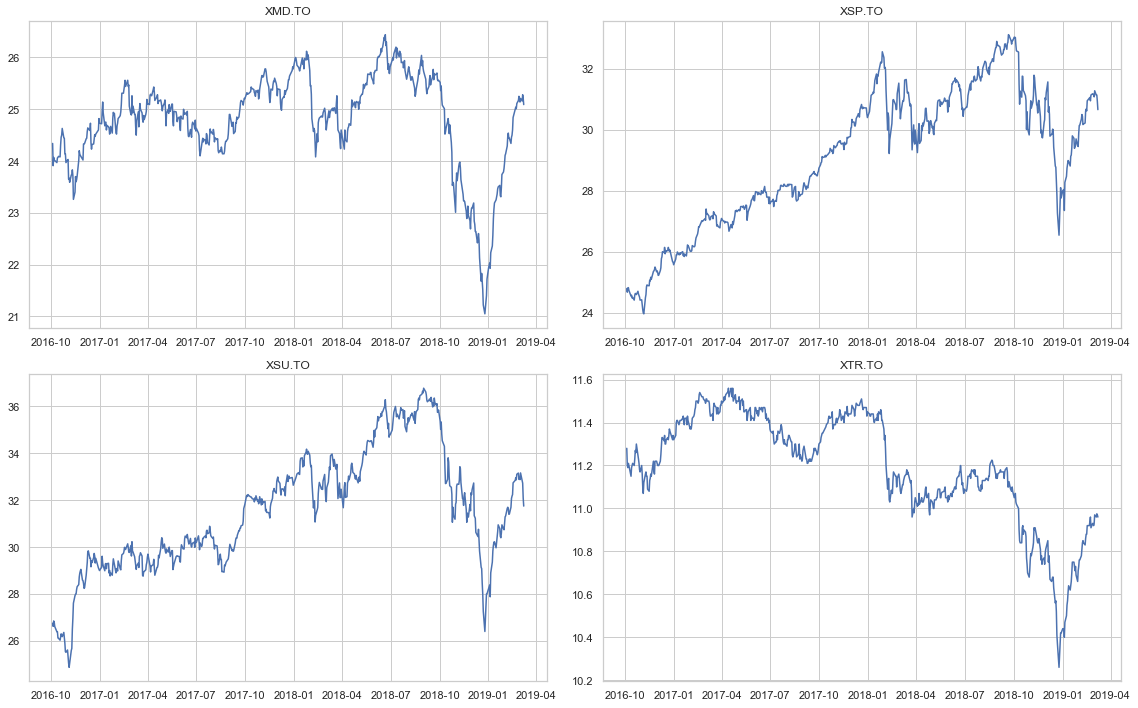

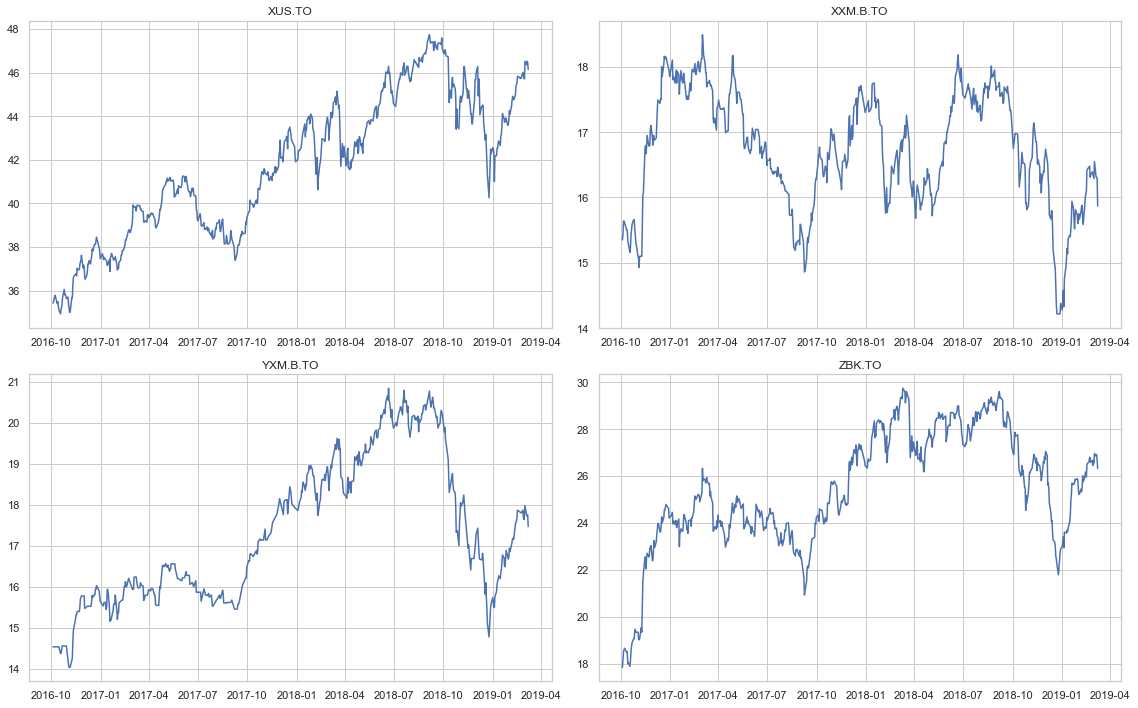

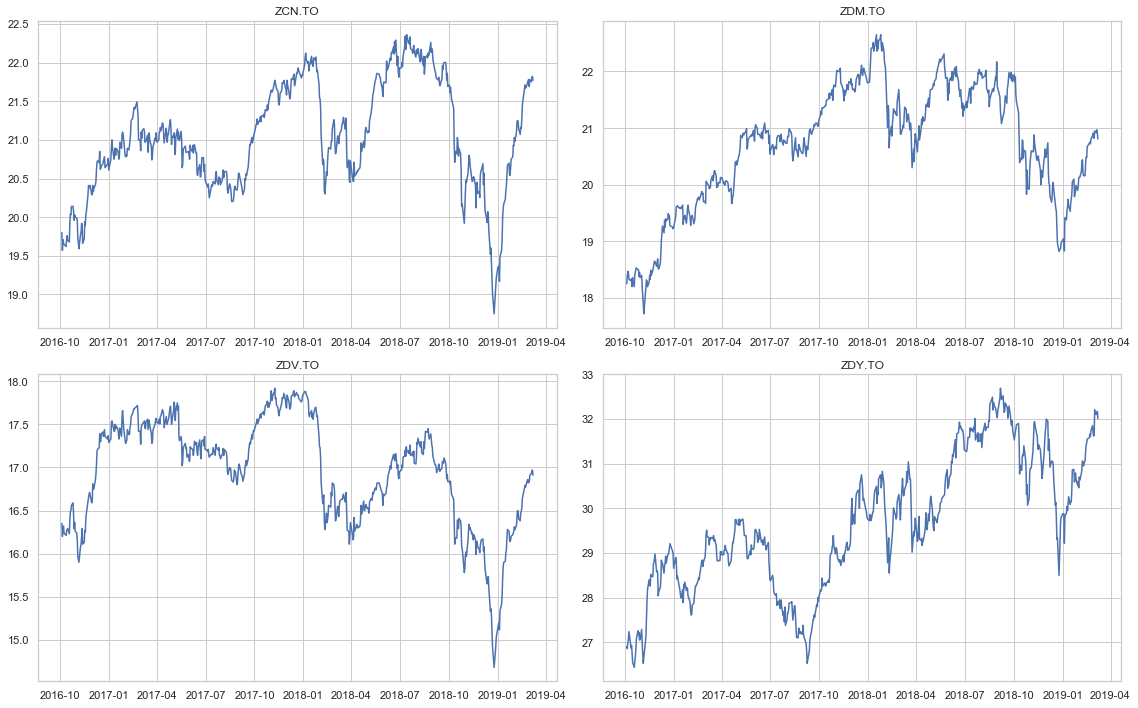

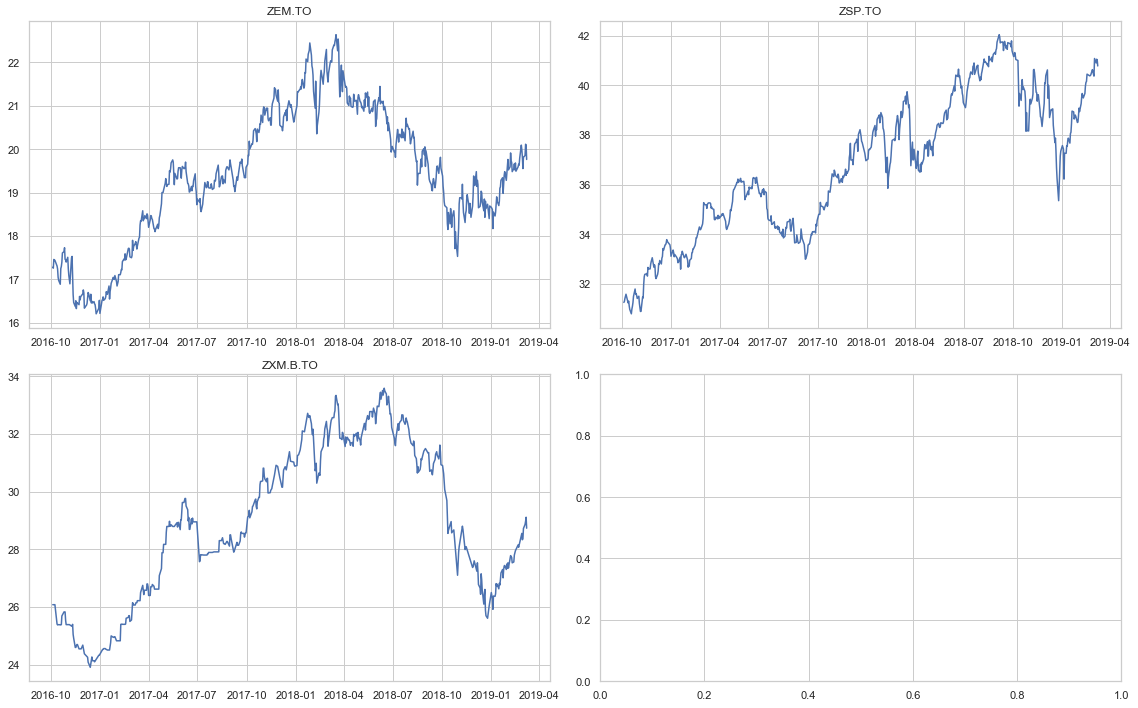

In [460]:
def chunks(l, n):
    print(l)
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

grouped = historicals.reset_index().set_index("end").groupby('symbol')

symbol_chunks = chunks(list(grouped.groups.keys()), 4)

for chunk in symbol_chunks:
    rows = math.ceil(len(chunk) / 2)
    fig, axs = plt.subplots(figsize=(16,10), nrows=rows, ncols=2)

    targets = zip(chunk, axs.flatten())
    for i, (key, ax) in enumerate(targets):
        ax.plot(grouped.get_group(key)['close'])
        ax.set_title(key)

    plt.tight_layout()
    plt.show()

In [526]:
historicals['daily_returns'] = historicals.groupby(level='symbol')['close'].apply(lambda x: x.pct_change())
historicals['total_returns'] = historicals.groupby(level='symbol')['daily_returns'].apply(lambda x: 
                                                                                          (1 + x).cumprod() - 1)

symbol
AAAA.VN     AxesSubplot(0.125,0.2;0.775x0.68)
AAXJ        AxesSubplot(0.125,0.2;0.775x0.68)
ACWI        AxesSubplot(0.125,0.2;0.775x0.68)
ACWV        AxesSubplot(0.125,0.2;0.775x0.68)
AFK         AxesSubplot(0.125,0.2;0.775x0.68)
AGG         AxesSubplot(0.125,0.2;0.775x0.68)
AGQ         AxesSubplot(0.125,0.2;0.775x0.68)
AOA         AxesSubplot(0.125,0.2;0.775x0.68)
ASHX        AxesSubplot(0.125,0.2;0.775x0.68)
AUSE        AxesSubplot(0.125,0.2;0.775x0.68)
BCEKF       AxesSubplot(0.125,0.2;0.775x0.68)
BIL         AxesSubplot(0.125,0.2;0.775x0.68)
BIV         AxesSubplot(0.125,0.2;0.775x0.68)
BKLN        AxesSubplot(0.125,0.2;0.775x0.68)
BLOK        AxesSubplot(0.125,0.2;0.775x0.68)
BLV         AxesSubplot(0.125,0.2;0.775x0.68)
BND.TO      AxesSubplot(0.125,0.2;0.775x0.68)
BOND        AxesSubplot(0.125,0.2;0.775x0.68)
BOTZ        AxesSubplot(0.125,0.2;0.775x0.68)
BRZU        AxesSubplot(0.125,0.2;0.775x0.68)
BSV         AxesSubplot(0.125,0.2;0.775x0.68)
BWZ         AxesSubplot(0.1

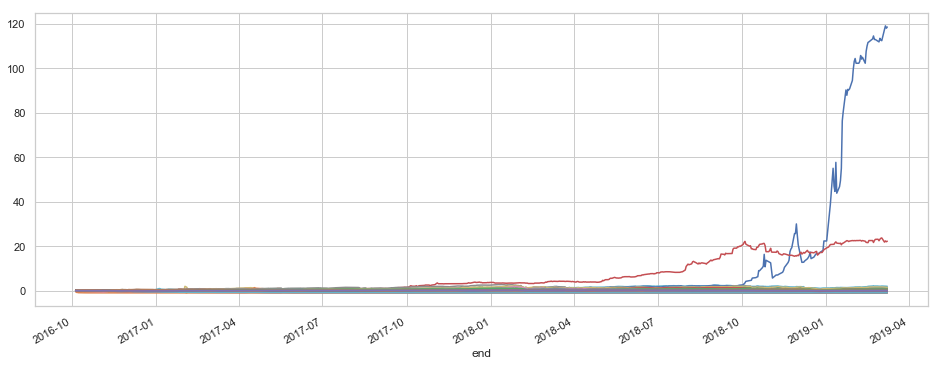

In [527]:
plt.figure(figsize=(16, 6))
historicals.reset_index().set_index("end").groupby('symbol')['total_returns'].plot()

In [528]:
historicals.groupby(level="symbol")["total_returns"].nth(-1).sort_values()

symbol
GBSNQ       -1.000000
TVIX        -0.981335
UVXY        -0.971374
HYD.TO      -0.865385
SLXXF       -0.817741
SQQQ        -0.778731
SDOW        -0.730214
MVRBF       -0.699739
HNU.TO      -0.698370
FAZ         -0.692617
SVXY        -0.661861
TAO.TO      -0.638298
SPXS        -0.627809
SPXU        -0.627571
EDZ         -0.570407
HND.TO      -0.543375
CANE        -0.504701
HOD.TO      -0.496460
BCEKF       -0.492683
AGQ         -0.475615
SDS         -0.462121
XES         -0.425858
FCG         -0.378154
PZA.TO      -0.354880
PCY.TO      -0.352941
FRAK        -0.332376
SLVO        -0.324604
TUR         -0.299842
TMF         -0.299342
GDXJ        -0.288011
              ...    
VONG         0.403321
UWM          0.404694
MILN         0.430576
PALL         0.438213
ZBK.TO       0.474510
PNQI         0.476796
HFU.TO       0.480460
HXQ.TO       0.492504
PPA          0.495729
TNA          0.509362
URTY         0.518418
SSO          0.574688
XAR          0.582241
CYB.TO       0.590258
SOX

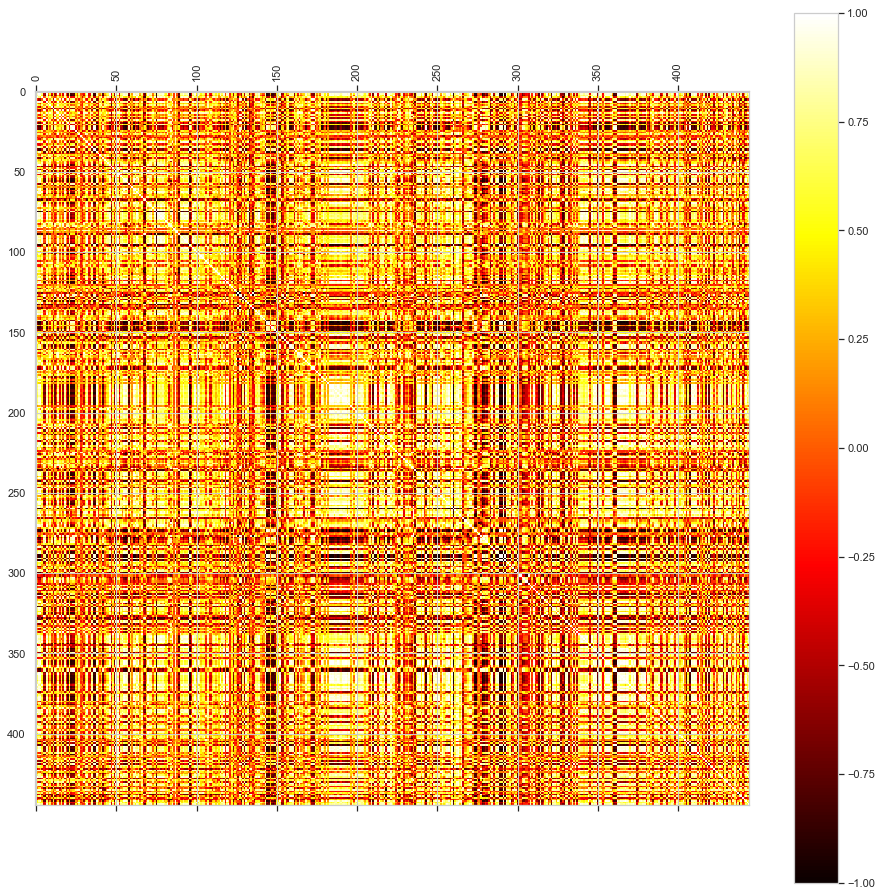

In [530]:
price_corr = historicals.reset_index().pivot('end','symbol')['close'].corr()

alpha = list(symbols.values())

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
cax = ax.matshow(price_corr, interpolation='nearest', cmap='hot')
fig.colorbar(cax)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.set_xticklabels(['']+alpha)
# ax.set_yticklabels(['']+alpha)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [514]:
price_corr

symbol,ACWI,ACWV,AFK,BOTZ,CBH.TO,CBO.TO,CDZ.TO,CEW.TO,CGL.C.TO,CGR.TO,...,ZLC.TO,ZMT.TO,ZPL.TO,ZPR.TO,ZPS.L.TO,ZRE.TO,ZRR.TO,ZSP.TO,ZWB.TO,ZXM.B.TO
symbol,,,,,,,,,,,,,,,,,,,,,
ACWI,1.000000,0.935933,0.737186,0.937227,-0.752895,-0.784423,0.045212,0.728478,-0.060920,-0.144404,...,-0.040573,0.912470,-0.106311,0.656963,-0.377498,0.770746,-0.472277,0.821687,0.660342,0.914032
ACWV,0.935933,1.000000,0.519356,0.794840,-0.833974,-0.855400,-0.104343,0.535095,-0.013507,0.031654,...,-0.123073,0.883196,-0.098310,0.431738,0.311615,0.888733,-0.526533,0.890816,0.487483,0.769296
AFK,0.737186,0.519356,1.000000,0.874618,-0.292582,-0.338453,0.085380,0.654026,0.181779,-0.378286,...,0.250686,0.631118,0.113389,0.687180,-0.596335,0.259943,-0.202144,0.284364,0.521855,0.800950
BOTZ,0.937227,0.794840,0.874618,1.000000,-0.571879,-0.619624,0.085404,0.758169,-0.022262,-0.309302,...,0.104162,0.831869,0.002557,0.754721,-0.695927,0.536136,-0.358689,0.608837,0.661751,0.919671
CBH.TO,-0.752895,-0.833974,-0.292582,-0.571879,1.000000,0.993802,0.343539,-0.362946,0.150892,0.217081,...,0.558531,0.383402,0.463009,-0.209849,-0.259435,-0.808390,0.636163,-0.841744,-0.331571,-0.553697
CBO.TO,-0.784423,-0.855400,-0.338453,-0.619624,0.993802,1.000000,0.356011,-0.370688,0.150655,0.237263,...,0.509061,0.453726,0.418852,-0.257153,-0.110307,-0.803442,0.617551,-0.841405,-0.333522,-0.605435
CDZ.TO,0.045212,-0.104343,0.085380,0.085404,0.343539,0.356011,1.000000,0.597772,-0.348309,0.285643,...,0.281543,0.872822,0.035276,0.463073,-0.214934,-0.051139,0.079428,-0.037441,0.655642,0.044010
CEW.TO,0.728478,0.535095,0.654026,0.758169,-0.362946,-0.370688,0.597772,1.000000,-0.291076,-0.148408,...,0.000042,0.888395,-0.205672,0.778858,-0.568673,0.424158,-0.362942,0.513791,0.959712,0.668846
CGL.C.TO,-0.060920,-0.013507,0.181779,-0.022262,0.150892,0.150655,-0.348309,-0.291076,1.000000,0.220866,...,0.321755,0.013543,0.411469,-0.262420,0.560985,0.041483,0.171606,-0.060812,-0.364475,0.055535
